In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_to_pybeh as pb
from pandas_to_pybeh import *
import seaborn as sns
import os,sys,argparse,glob

import json
from  matplotlib.ticker import FuncFormatter

pd.set_option('display.max_columns', 1000)
import warnings
warnings.filterwarnings("ignore")

# os.chdir("/home1/leochang/elemem_pilot/")
# CONFIG_FILE = '.config_ipynb'
# if os.path.isfile(CONFIG_FILE):
#     with open(CONFIG_FILE) as f:
#         sys.argv = f.read().split()
# else:
#     print("PUT IN SUBJECT SESSION INFO")
 
# change directory location if needed:    
data_dir = "/scratch/new_courier_pilot/" ## pilot data directory
# data_dir = "/scratch/EFRCourier_reports/" ## hospital data directory

In [16]:
# create a df with a specific subject and session
def read_sub_sess_data(data_dir, sub, sess):
    
    file_name = "{}_sess_{}.csv".format(sub, sess)    
    df = pd.read_csv(os.path.join(data_dir, file_name))
    df = df.drop(columns=['Unnamed: 0'])
    
    return df

# create a df with all sessions for a specific subject 
def read_sub_data(data_dir, sub):
    df = None
    
    os.chdir(data_dir)
    for file in glob.glob("*.csv"):
        if sub in file:
            tmp = pd.read_csv(file)
            tmp = tmp.drop(columns=['Unnamed: 0'])
            df = tmp if df is None else df.append(tmp)
    
    return df

In [17]:
# # example:
# PILOT1_evs = read_sub_sess_data(data_dir, "Matt", 0)
# PILOT1_evs

# # if using real (hospital) subjects' data:
# PILOT1_evs = read_sub_sess_data(data_dir, "R1620J", 0)
# PILOT1_evs

In [18]:
# or create a df with all subjects saved in the directory
full_evs = None

os.chdir(data_dir)
for file in glob.glob("*.csv"):
    df = pd.read_csv(file)
    df = df.drop(columns=['Unnamed: 0'])
    full_evs = df if full_evs is None else full_evs.append(df)

# full_evs

In [19]:
# full_evs['subject'].unique()

In [20]:
# full_evs = None

# # since no argument has been added in, we will look at all subject, all session data
# if len(sys.argv) == 1:   
#     os.chdir(data_dir)
#     for file in glob.glob("*.csv"):
#         df = pd.read_csv(file)
#         df = df.drop(columns=['Unnamed: 0'])
#         full_evs = df if full_evs is None else full_evs.append(df)
        
# else:
#     # initialize parser
#     parser = argparse.ArgumentParser()
#     # adding optional argument
#     parser.add_argument("-S", "--Subject", nargs="*", help = "type subject id that you want to generate report for")
#     parser.add_argument("-s", "--Session", nargs="?", type=int, help = "type session number that you want to generate report for")
#     args = parser.parse_args()
    
#     # multiple subjects
#     if type(args.Subject) != str:
#         for sub in args.Subject:
#             sub_evs = read_sub_data(data_dir, sub)
#             full_evs = sub_evs if full_evs is None else full_evs.append(sub_evs)
    
#     # single subject
#     else:
#         # single session
#         if args.Session:
#             full_evs = read_sub_sess_data(data_dir, args.Subject, args.Session)
#         # all sessions
#         else:
#             full_evs = read_sub_data(data_dir, args.Subject)
    

In [21]:
word_evs = full_evs.query('type == "WORD"')
deliv_table = word_evs.groupby(["subject", "session"]).agg({"trial":pd.Series.nunique}).reset_index()
print('Total number of subjects in report: ',len(deliv_table['subject'].unique()))
print('Total number of session in report: ', len(deliv_table['session']))
deliv_table

Total number of subjects in report:  10
Total number of session in report:  12


,subject,session,trial
0,Arnav,0,4
1,Chris_Courier,0,4
2,Colin_Annotated,1,5
3,Matt,0,3
4,PILOT1,0,2
5,PILOT2,0,2
6,PILOT3,0,3
7,PILOT4,0,2
8,PILOT4,1,1
9,PILOT5,1,2


# Navigation 

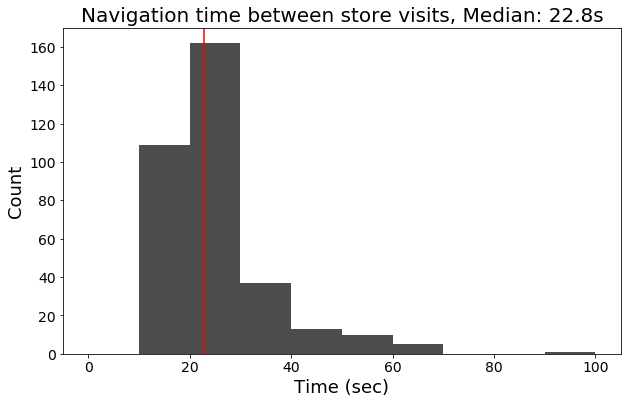

In [22]:
word_evs = full_evs.query('type == "WORD"')
total_delivery_time = []

for trial, trial_evs in word_evs.groupby("trial"):
    delivery_times = np.diff(trial_evs.mstime) / 1000
    total_delivery_time.extend(delivery_times)

median = np.round(np.median(total_delivery_time),1)
    
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(total_delivery_time, color=(0.3,0.3,0.3), range=(0, 100))
plt.axvline(np.median(total_delivery_time), color="r")
plt.title("Navigation time between store visits, Median: {}s".format(median), fontsize=20)
plt.xlabel("Time (sec)", fontsize=18)
plt.ylabel("Count", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# make ticks larger
plt.show()

# Pointing task

In [12]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.pi/18

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor='C0', fill=True, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [13]:
pointing_evs = full_evs[full_evs.type == 'pointing finished']
filt_point_evs = pointing_evs[(pointing_evs['presX']) != -999.00]
# print(len(pointing_evs))
# print(len(filt_point_evs))
#find the raw pointing error for each pointing task completed
submitted_point = filt_point_evs['pointed direction (degrees)'] 
correct_point = filt_point_evs['correct direction (degrees)']
difference = np.radians(submitted_point - correct_point)
difference = (difference + np.pi) % (2 * np.pi) - np.pi
difference = np.array(difference)

#find the store locations for all stores visited 
store_evs = full_evs[~pd.isnull(full_evs['store position'])]
store_evs = store_evs[~pd.isnull(store_evs['store'])]
stores = store_evs.groupby('store')  
stores = stores.agg('mean')[['storeX', 'storeZ']]
storeX = stores['storeX'].values
storeZ = stores['storeZ'].values

pos_angles = []
correct_point = np.array(correct_point)
x = 0
for i, finished_row in filt_point_evs.iterrows():
    position_x, position_z = finished_row[['presX', 'presZ']]
    difference_x = (storeX - position_x)
    difference_z = (storeZ - position_z)
    angle = np.arctan2(difference_z, difference_x) 
    angle = (angle + np.pi) % (2 * np.pi) - np.pi
    angle = np.abs(angle)
    pos_angles.append(np.median(angle - correct_point[x]))
    x = x + 1

# apply correction of pointing error and wrap again to display nicely
pos_angles = np.array(pos_angles)
pos_angles = np.radians(pos_angles)
point_error = difference/ pos_angles
point_error = (point_error + np.pi) % (2 * np.pi) - np.pi


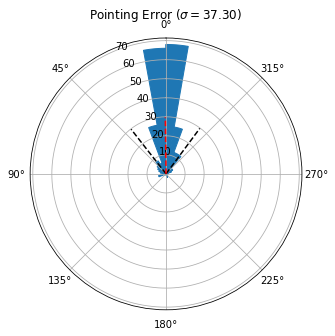

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics

plt.figure(figsize=(5,5))
ax = plt.subplot(111, projection = 'polar')

n, bins, _ = circular_hist(ax, point_error, offset = np.pi/2, bins = 30, density = False)
plt.title('Pointing Error ($\sigma = {:.2f}$)'.format(point_error.std()*180/np.pi))
ax.vlines([np.mean(point_error)+point_error.std(), np.mean(point_error)-point_error.std()], ymin = 0, 
          ymax = np.max(point_error.size/np.pi)*0.35, ls = "--", colors = 'k')
ax.vlines(np.mean(point_error), ymin = 0, ymax=np.max(point_error.size/np.pi)*0.35,ls = '--', colors = 'r')
plt.show()


# Recall Rates

In [24]:
cued_rec_word = full_evs.query('type == "CUED_REC_WORD"')
for i, row in cued_rec_word.iterrows():
    if row['item'] == row['cued_item']:
        full_evs.at[i, "recalled"] = 1
    else:
        full_evs.at[i, "recalled"] = 0

FFR_item = full_evs.query('type == "FFR_REC_WORD"')
FFR_item = FFR_item.drop_duplicates(subset=["item"])
FFR_item["recalled"] = FFR_item["serialpos"] > 0

In [25]:
def add_cued_recalled(events):
    def find_recall(row):
        itemno = row['itemno']
        recalls = events[(events["type"] == 'CUED_REC_WORD') &
                         (events["session"] == row["session"]) &
                         (events["trial"] == row["trial"])]["itemno"].values
        return 1 if itemno in recalls else 0

    events = events.sort_values("mstime")
    events.loc[events["type"] =="WORD", "cued_recalled"] = events.loc[events["type"] == "WORD"].apply(find_recall, axis=1)
    return events

def add_store_recalled(events, df):
    def calculate_recall(row):
        sess_df = events[(events.subject == row.subject) & (events.session == row.session)]
        stores = sess_df.query('type == "WORD"').store.unique()
        recalls = sess_df.query('type == "FSR_REC_WORD"').item.unique()
        recall_prob = np.sum([1 for store in stores if store in recalls]) / len(stores)
        return recall_prob
    
    df["final_store_prob"] = df.apply(calculate_recall, axis=1)
    return df

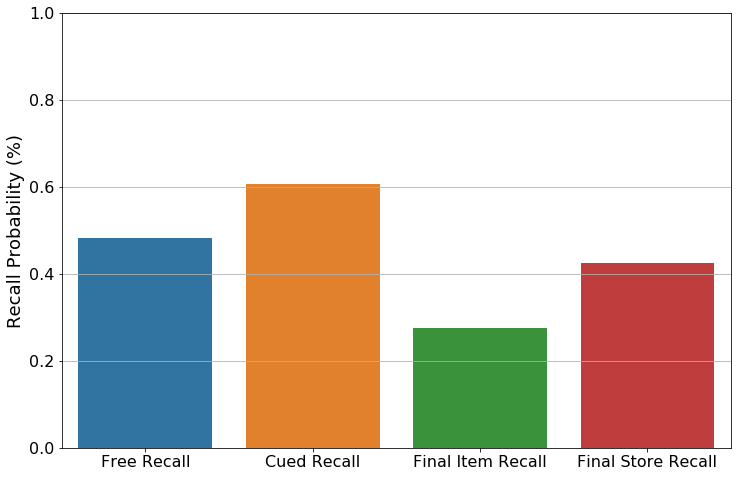

In [26]:
full_evs = add_cued_recalled(full_evs)
recall_df = full_evs.query('type == "WORD"').groupby(["subject", "session"]).agg({"recalled":"mean", 
                                                                                  "cued_recalled":"mean",
                                                                                  "final_recalled":"sum", 
                                                                                  "serialpos":"count"}).reset_index()
recall_df["final_item_prob"] = recall_df["final_recalled"] / recall_df["serialpos"]
recall_df = add_store_recalled(full_evs, recall_df)

recall_plot_df = pd.DataFrame(columns=["subject", "session", "recall_type", "recall_prob"])
for i, row in recall_df.iterrows():
    recall_plot_df = recall_plot_df.append({"subject":row.subject, "session":row.session, "recall_type":"Free Recall", "recall_prob":row.recalled}, ignore_index=True)
    recall_plot_df = recall_plot_df.append({"subject":row.subject, "session":row.session, "recall_type":"Cued Recall", "recall_prob":row.cued_recalled}, ignore_index=True)
    recall_plot_df = recall_plot_df.append({"subject":row.subject, "session":row.session, "recall_type":"Final Item Recall", "recall_prob":row.final_item_prob}, ignore_index=True)
    recall_plot_df = recall_plot_df.append({"subject":row.subject, "session":row.session, "recall_type":"Final Store Recall", "recall_prob":row.final_store_prob}, ignore_index=True)


fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=recall_plot_df, x="recall_type", y="recall_prob", ci=None)
plt.tick_params(labelsize=16)
plt.xlabel("")
ax.yaxis.grid()
plt.ylim([0,1])
plt.ylabel("Recall Probability (%)", fontsize=18)
plt.show()

- Above recall probabilities were calculated while ignoring any subsequent key presses

# Intrusion Analysis

In [27]:
#FREE RECALL
# Correct Rejection : intrusion != 0 and keypress == True
# False Alarm: intrusion == 0 / recalled == 1 and keypress == True
# Miss : intrusion != 0 and keypress == False
# Hit: intrusion == 0 and keypress == False

#CUED RECALL                              #intra-list intrusion
# Correct Rejection : ( intrusion != 0 | (intrusion == 0 and recalled == 0) ) and keypress == True
# False Alarm: recalled == 1 and keypress == True
# Miss : ( intrusion != 0 | (intrusion == 0 and recalled == 0) ) and keypress == False
# Hit: intrusion == 0 and recalled == 1 and keypress == False

intrusion_df = pd.DataFrame(columns=["subject", "session", "trial", "type", "intrusion_type"])

rec_evs = full_evs.query('type == "REC_WORD"')
for i, row in rec_evs.iterrows():
    if row.intrusion != 0 and row.keypress == True:
        intrusion_type = "intrusions rejected"
    elif (row.intrusion == 0 or row.recalled == 1) and row.keypress == True:
        intrusion_type = "correct recalls rejected"
    elif row.intrusion != 0 and row.keypress != True:
        intrusion_type = "intrusions accepted"
    elif row.intrusion == 0 and row.keypress != True:
        intrusion_type = "correct recalls accepted"
    else:
        intrusion_type = "None"
    
    intrusion_df = intrusion_df.append({"subject":row.subject, 
                                        "session":row.session,
                                        "trial":row.trial,
                                        "type":"Free Recall",
                                        "intrusion_type":intrusion_type
                                       }, ignore_index=True)
    
cued_rec_evs = full_evs.query('type == "CUED_REC_WORD"')
for i, row in cued_rec_evs.iterrows():
    if ( row.intrusion != 0 or (row.intrusion == 0 and row.recalled == 0) ) and row.keypress == True:
        intrusion_type = "intrusions rejected"
    elif row.recalled == 1 and row.keypress == True:
        intrusion_type = "correct recalls rejected"
    elif ( row.intrusion != 0 or (row.intrusion == 0 and row.recalled == 0) ) and row.keypress != True:
        intrusion_type = "intrusions accepted"
    elif row.intrusion == 0 and row.recalled == 1 and row.keypress != True:
        intrusion_type = "correct recalls accepted"
    else:
        intrusion_type = "None"
    
    intrusion_df = intrusion_df.append({"subject":row.subject, 
                                        "session":row.session,
                                        "trial":row.trial,
                                        "type":"Cued Recall",
                                        "intrusion_type":intrusion_type
                                       }, ignore_index=True)
    
ffr_rec_evs = full_evs.query('type == "FFR_REC_WORD"')
for i, row in ffr_rec_evs.iterrows():
    if row.intrusion < 0 and row.keypress == True:
        intrusion_type = "intrusions rejected"
    elif row.recalled == 1 and row.keypress == True:
        intrusion_type = "correct recalls rejected"
    elif row.intrusion < 0 and row.keypress != True:
        intrusion_type = "intrusions accepted"
    elif row.intrusion >= 0 and row.keypress != True:
        intrusion_type = "correct recalls accepted"
    else:
        intrusion_type = "None"
    
    intrusion_df = intrusion_df.append({"subject":row.subject, 
                                        "session":row.session,
                                        "trial":row.trial,
                                        "type":"Final Free Recall",
                                        "intrusion_type":intrusion_type
                                       }, ignore_index=True)

In [28]:
table = intrusion_df.groupby(["subject", "session", "trial", "type", "intrusion_type"]).size().reset_index(name='counts')

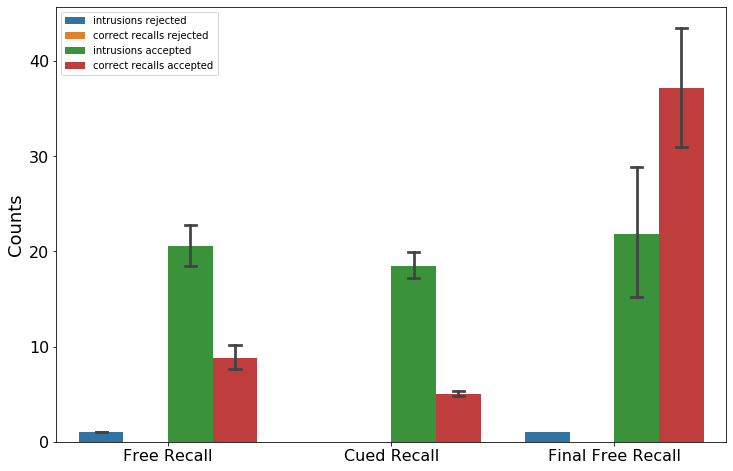

In [40]:
fig, ax = plt.subplots(figsize=(12,8))
p = sns.barplot(data=table, 
                x="type", 
                order=["Free Recall", "Cued Recall", "Final Free Recall"],
                y="counts", 
                hue="intrusion_type", 
                hue_order=["intrusions rejected", 
                           "correct recalls rejected", 
                           "intrusions accepted", 
                           "correct recalls accepted"],
#                 palette="crest",
                ci=68,
                capsize=0.05)
# plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("")
plt.ylabel("Counts", fontsize=18)
plt.gca().legend().set_title('')
# ax.yaxis.grid()
plt.show()

** Note that this is the sum over all delivery days

- Intrusions rejected: Intrusions that were correctly rejected
- Correct recalls rejected: Correct recalls that were incorrectly rejected
- Intrusions accepted: Correct recalls that were not rejected
- Correct recalls accepted: Intrusions that were not rejected

In [29]:
ci=None if len(full_evs.subject.unique()) < 5 else 68

# SPC

In [ ]:
spc_df = full_evs.query("type=='WORD'").groupby(['subject', 'session', 'serialpos']) \
                                       .agg({'recalled':np.nanmean}).reset_index()

fig, ax = plt.subplots(figsize=(12, 8))
spc = sns.pointplot(data=spc_df, x='serialpos', y='recalled', ci=ci,
                    color='k', err_style='bars', capsize=.3, label="SPC")

plt.xlabel('Serial Position', fontsize=18)
plt.ylabel('Recall Probability (%)', fontsize=18); plt.ylim([0,1])
ax.yaxis.grid()
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title("Serial Position Curve", fontsize=20)
plt.show()

In [ ]:
recword = full_evs.query('type=="REC_WORD"')
recword['pos'] = recword.groupby(['subject', 'session', 'trial']).cumcount()
first_recall_df = recword.query('pos == 0 and serialpos >= 0')
first_recall_df = first_recall_df.groupby(
    ['subject', 'session', 'serialpos']).agg(
    {'recalled': 'count'}).unstack(fill_value=0).stack().reset_index()
first_recall_df['n_lists'] = first_recall_df.groupby(['subject'])['recalled'].transform('sum')
first_recall_df['prob'] = first_recall_df['recalled'] / first_recall_df['n_lists']

fig, ax = plt.subplots(figsize=(12, 8))
pfr = sns.pointplot(data=first_recall_df, x='serialpos', y='prob', ci=ci,
                    color='k', err_style='bars', capsize=.1)
plt.xlabel('Serial Position', fontsize=18)
plt.ylabel('Recall Probability (%)', fontsize=18); plt.ylim([0,1])
ax.yaxis.grid()
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title("Probability of First Recall", fontsize=20)
plt.show()

# Lag-CRP

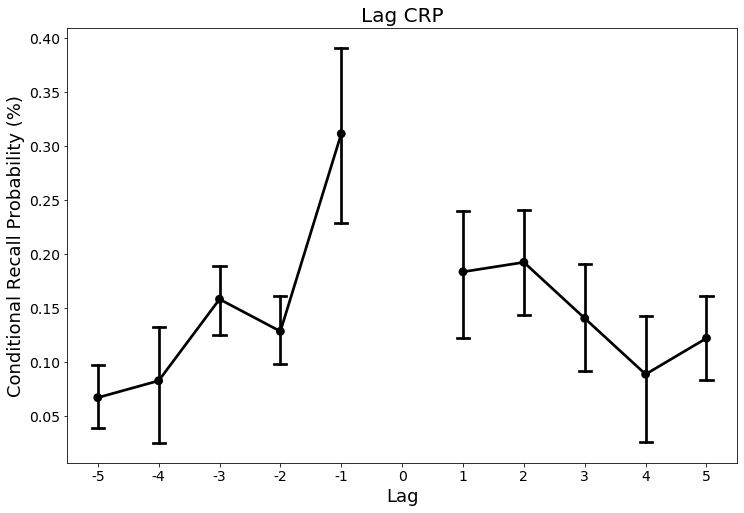

In [34]:
full_evs['itemno'] = full_evs['item'].astype('category').cat.codes
crp_df = full_evs.groupby(['subject']).apply(
    pb.pd_crp,
    itemno_column='itemno',
    list_index=['subject', 'session', 'trial'],
    lag_num=5).reset_index()

fig, ax = plt.subplots(figsize=(12,8))
crp = sns.pointplot(data=crp_df, x='lag', y='prob', ci=ci,
                    color='k', err_style='bars', capsize=.2)
plt.title("Lag CRP", fontsize=20)
plt.xlabel("Lag", fontsize=18)
plt.ylabel("Conditional Recall Probability (%)", fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
# plt.grid()
# p.yaxis.grid()
plt.show()

# Spatial CRP

In [35]:
def isolate_storeX(row):
    store_location = eval(row['store position'])
    return store_location[0]

def isolate_storeZ(row):
    store_location = eval(row['store position'])
    return store_location[2]

def isolate_playerX(row):
    player_position = eval(row['player position'])
    return player_position[0]

def isolate_playerZ(row):
    player_position = eval(row['player position'])
    return player_position[2]

full_evs.loc[full_evs["type"] == "WORD", "storeX"] = full_evs.loc[full_evs["type"] == "WORD"].apply(isolate_storeX, axis=1)
full_evs.loc[full_evs["type"] == "WORD", "storeZ"] = full_evs.loc[full_evs["type"] == "WORD"].apply(isolate_storeZ, axis=1)
full_evs.loc[full_evs["type"] == "WORD", "presX"] = full_evs.loc[full_evs["type"] == "WORD"].apply(isolate_playerX, axis=1)
full_evs.loc[full_evs["type"] == "WORD", "presZ"] = full_evs.loc[full_evs["type"] == "WORD"].apply(isolate_playerZ, axis=1)

In [36]:
def get_new_item_id(item, wordpool=[]):
    if item not in wordpool:
        return -999
    return wordpool.index(item)

# need to redo itemno because not using all items in wordpool
word_evs = full_evs.query('type == "WORD" and itemno > -1')
wordpool_subset = word_evs.item.unique().tolist()
full_evs['itemno'] = full_evs['item'].transform(get_new_item_id, wordpool=wordpool_subset)

In [37]:
word_evs = full_evs.query('itemno != -999 and type == "WORD"')
store_items = word_evs[['store', 'item', 'itemno']].drop_duplicates()
sub_store_locs = word_evs[['store', "storeX", "storeZ", 'subject']].drop_duplicates()
sub_store_locs['type'] = 'WORD_VALS'
loc_evs = sub_store_locs.merge(store_items)
loc_evs = loc_evs.sort_values('itemno')
test_evs = full_evs.append(loc_evs)

In [38]:
bins = [12.96160383, 41.99123618, 61.53639199, 77.73374529, 97.11224258]

spatial_crp = test_evs.groupby('subject').apply(
    pb.pd_sem_crp, list_index=['subject', 'session', 'trial'], 
    sim_columns=['storeX', 'storeZ'], bins=bins, ret_counts=False).reset_index()

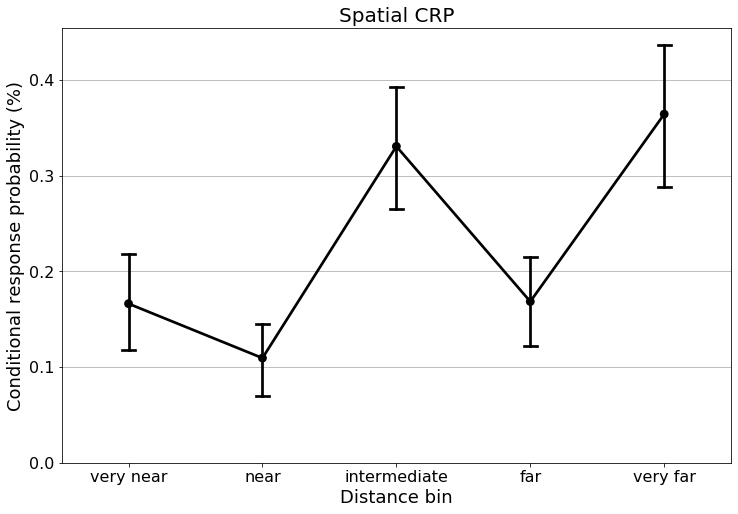

In [39]:
fig = plt.figure(figsize = (12,8))
fig.patch.set_facecolor('white')
ax1 = sns.pointplot(data=spatial_crp, x='sem_bin', y='prob', marker = 'o', color = 'black', capsize=0.1, ci=ci)
ax1.set_xlabel('Distance bin', fontsize=18)
ax1.set_xticklabels(["very near", "near", "intermediate", "far", "very far"], fontsize=14)
ax1.set_ylabel('Conditional response probability (%)', fontsize=18)
plt.yticks(fontsize=14)
ax1.yaxis.grid()
plt.tick_params(labelsize=16)
plt.ylim(0)
plt.title("Spatial CRP", fontsize=20)
plt.show()

# Navigation Trajectory

In [40]:
import random
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

if len(deliv_table) > 3:
    print("Too many subjects and sessions to plot all trajectories")
else:
    for i, row in deliv_table.iterrows():

        print("{} session {}".format(row.subject, row.session))
        # pull up jsonl file from data2 directory
        file_name = "{}/session_{}/session.jsonl".format(row.subject, row.session)
        file_dir = os.path.join(data_dir, file_name)

        new_file = []
        for line in open(file_dir, "r"):
            # replace this specific entry to empty string
            if '"point condition":SerialPosition,' in line:
                line = line.replace('"point condition":SerialPosition,', '')
            elif '"point condition":SpatialPosition,' in line:
                line = line.replace('"point condition":SpatialPosition,', '')
            elif '"point condition":Random,' in line:
                line = line.replace('"point condition":Random,', '')

            data_dict = json.loads(line)
            new_file.append(data_dict)

        with open("session_tmp.jsonl", "w") as outfile:
            for line in new_file:
                json.dump(line, outfile)
                outfile.write('\n')

        log = pd.read_json("session_tmp.jsonl", lines=True)
        log = log[(log.type=='PlayerTransform')|(log.type=='object presentation begins')]

        def extract_position(row):
            if row.type=='PlayerTransform':
                return (row['data']['positionX'], row['data']['positionY'], row['data']['positionZ'])
            elif row.type=='object presentation begins':
                return eval(row['data']['player position'])
            else:
                return np.nan

        log['location']=log.apply(extract_position, axis=1)
        log['trial']=log.apply(lambda row: row['data']['trial number'] if np.isin('trial number', list(row['data'].keys())) else np.nan, axis=1)
        movements = log.fillna(method='pad').dropna()
        sess_pos = np.stack(list(map(list, movements.location.values)))

        group_mov = movements.groupby('trial')    
        dd_list = np.array(list(group_mov.groups.keys())).astype(int)
        pos_by_list = [np.stack(list(map(list, group_mov.get_group(i)['location']))) for i in dd_list]

        fig, ax = plt.subplots(len(dd_list)//2 + len(dd_list)%2, 2, 
                               figsize= (20, 8*(len(dd_list)//2 + len(dd_list)%2)) )
        ax = ax.ravel()


        for i, dd in enumerate(dd_list):
            store_locs = log['data'][(log.type=='object presentation begins')&(log.trial==i)].apply(lambda json: eval(json['store position']))
            store_names = log['data'][(log.type=='object presentation begins')&(log.trial==i)].apply(lambda json: json['store name'])
            list_stores = np.stack(list(map(list, store_locs.values)))


            points = np.array([pos_by_list[i][:, 0], pos_by_list[i][:, 2]]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)

            # don't count motionless time
            segments = segments[1:][np.any(np.diff(segments, axis=0)!=0, axis=(1, 2))]
            lc = LineCollection(segments, cmap='copper_r')
            # Set the values used for colormapping
            lc.set_array(np.linspace(0, 1, len(segments)))
            lc.set_linewidth(3); lc.set_alpha(.6)
            line = ax[i].add_collection(lc)
            ax[i].scatter(list_stores[:, 0], list_stores[:, 2])
            texts = []
            for x, y, name, order in zip(list_stores[:, 0], list_stores[:, 2], store_names, np.arange(len(store_names))):
                texts.append(ax[i].text(x-10, y+5, name.capitalize() + ' ({})'.format(order)))
            ax[i].set_title('Delivery Day %d' %(dd+1), fontsize=20)
            ax[i].set_xticklabels([]);ax[i].set_yticklabels([])
        #         adjust_text(texts, expand_text=(1.2, 1.2))


            positions = []
            tmp_texts = []
            for text in texts:
        #             print(text.get_position())
                positions.append(text.get_position())
                tmp_texts.append(text)

            point1_1 = (26.700000000000003, 64.1)
            if point1_1 in positions:
                text1 = tmp_texts[positions.index(point1_1)]
                text1.set_visible(False)
                ax[i].text(26.7, 54.1, text1.get_text())

            if ((25.1, 31.7) in positions) and ((48.3, 32.9) in positions):
                text1 = tmp_texts[positions.index((25.1, 31.7))]
                text2 = tmp_texts[positions.index((48.3, 32.9))]

                text1.set_visible(False); text2.set_visible(False)

                ax[i].text(15.1, 31.7, text1.get_text())
                ax[i].text(52.3, 32.9, text2.get_text())

            point3_1 = (4.5, -28.700000000000003); point3_2 = (25.4, -28.1); point3_3 = (52.3, -28.5)
            if (point3_1 in positions) and (point3_2 in positions):

                if point3_3 in positions:
                    text1 = tmp_texts[positions.index(point3_1)]
                    text2 = tmp_texts[positions.index(point3_2)]
                    text3 = tmp_texts[positions.index(point3_3)]

                    text1.set_visible(False); text2.set_visible(False); text3.set_visible(False)

                    ax[i].text(-10, -28.700000000000003, text1.get_text())
                    ax[i].text(20.4, -28.1, text2.get_text())
                    ax[i].text(61.3, -28.5, text3.get_text())
                else:
                    text1 = tmp_texts[positions.index(point3_1)]
                    text2 = tmp_texts[positions.index(point3_2)]

                    text1.set_visible(False); text2.set_visible(False)

                    ax[i].text(-7, -28.700000000000003, text1.get_text())
                    ax[i].text(25.4, -28.1, text2.get_text())

            elif (point3_2 in positions) and (point3_3 in positions):
                text1 = tmp_texts[positions.index(point3_2)]

                text1.set_visible(False)

                ax[i].text(10.4, -28.1, text1.get_text())

            point4_1 = (-13.1, -53.5); point4_2 = (4.6, -53.8); point4_3 = (22.200000000000003, -55.9)
            if (point4_1 in positions) and (point4_2 in positions):

                if point4_3 in positions:
                    text1 = tmp_texts[positions.index(point4_1)]
                    text2 = tmp_texts[positions.index(point4_2)]
                    text3 = tmp_texts[positions.index(point4_3)]

                    text1.set_visible(False); text2.set_visible(False); text3.set_visible(False)

                    ax[i].text(-20, -65.5, text1.get_text())
                    ax[i].text(0, -53.8, text2.get_text())
                    ax[i].text(30, -55.9, text3.get_text())
                else:
                    text1 = tmp_texts[positions.index(point4_1)]
                    text2 = tmp_texts[positions.index(point4_2)]

                    text1.set_visible(False); text2.set_visible(False)

                    ax[i].text(-20, -53.5, text1.get_text())
                    ax[i].text(5, -53.8, text2.get_text())

            elif (point4_2 in positions) and (point4_3 in positions):
                text1 = tmp_texts[positions.index(point3_2)]

                text1.set_visible(False)

                ax[i].text(0, -53.8, text1.get_text())


        fig.subplots_adjust(hspace=0.2, wspace=0.2)
        plt.tight_layout()
        cbar = fig.colorbar(line, ax=ax[:], location='right', shrink = 0.7)
        cbar.ax.tick_params(labelsize=16)
        cbar.ax.set_yticklabels(["Start", "", "", "", "", "End"])
        fig.set_facecolor('white')
        for a in ax:
            a.axis("off")
        plt.show()

Too many subjects and sessions


In [29]:
# !ONLY FOR ALL SUBJECT DATA REPORT!
if len(sys.argv) == 1:  
    os.chdir("/home1/leochang/elemem_pilot/")
    !jupyter nbconvert --to html elemem_behavioral_analysis.ipynb  --no-input
    !mv elemem_behavioral_analysis.html all_subject_report.html
    !mv all_subject_report.html ./reports/all_subject_report.html

In [46]:
#     read = cml.CMLReader(subject=R1620J, experiment=row['experiment'], session=row['session'])
